<a href="https://colab.research.google.com/github/advapplab/sentiment_analysis_election_2022/blob/main/weibo_wmmBERT_testing_Cya_check_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [231]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [232]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [233]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1. load and clean data

In [234]:
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx

File ‘df_sample.xlsx’ already there; not retrieving.



In [235]:
ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['positive']=1 #pos
#    ici_map_dict['posiitive']=1 #pos
#    ici_map_dict['neutral']=3 #ignore
#    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['negative']=0 #neg
 

len(ici_map_dict)

2

In [236]:
import pandas as pd

In [237]:
testing_pd = pd.read_excel('/content/df_sample.xlsx')

testing_pd = testing_pd[['text', 'cya_check_3']]
testing_pd = testing_pd.rename(columns={'cya_check_3':'label'})
testing_pd = testing_pd[(testing_pd['label'] == 'negative') | (testing_pd['label'] == 'positive')]


# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(123, 2)

In [238]:
#dirty data
testing_pd

,text,label
3,【这家民调蒋万安拉警报？ 郭正亮惊爆内幕：帮陈时中冲喜】对于《东森新闻》委托“雨晴民调公司”...,0
4,"【陈时中称蒋万安防疫主张抄袭自己 蒋万安：他防疫做得这么差 谁会想抄】<a href=""h...",0
5,【黑心快筛流入蒋万安：食药署责无旁贷、不是推给厂商就可卸责】针对黑心快筛流入市面，国民党台北...,0
6,"<a href=""https://m.weibo.cn/search?containeri...",0
7,很多人根本看不懂国际局势<br />一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。...,0
...,...,...
193,【蓝绿互打政二代 港媒预言最惨结局与最后赢家】国民党台北市议员徐巧芯日前公布民进党台北市长参...,0
194,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民<br...,0
197,【周玉蔻怎能霸占黄金时段？郭正亮爆：被“有分量”金主标下】资深媒体人周玉蔻日前攻击国民党台北...,0
198,额？？？这是蒋万安的竞选团队？？？,0


In [239]:
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
# title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"

#we have to find a way to delete the entire <span> tag. some posts will end up with only 2 or 3 characters after that. We can drop them. 
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [240]:
#clean data
testing_pd

,text,label
0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0
1,#台湾# 深圳卫视正午30分的微博视频,0
2,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...,0
3,#叨哥有话说# 批台名嘴周玉蔻口无遮拦，马英九：蒋万安应该要告她,0
4,很多人根本看不懂国际局势一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。直白一点说，...,0
...,...,...
114,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
115,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0
116,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0
117,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0


In [241]:
len(testing_pd.iloc[0]['text'])

134

In [242]:
#upsize minority class (positive). You can consider turning this cell off. With the current data (df_sample.xlsx) this will lead to a 0.840 accuracy. 
if number_classes == 2:
    from sklearn.utils import resample

    df_majority = testing_pd[testing_pd.label==0]
    df_minority = testing_pd[testing_pd.label==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df_majority.shape[0],    # to match majority class
                                    random_state=42) # reproducible results

    # Combine majority class with upsampled minority class
    testing_pd = pd.concat([df_majority, df_minority_upsampled])


In [243]:
num_label = len(testing_pd['label'].unique())
num_label

2

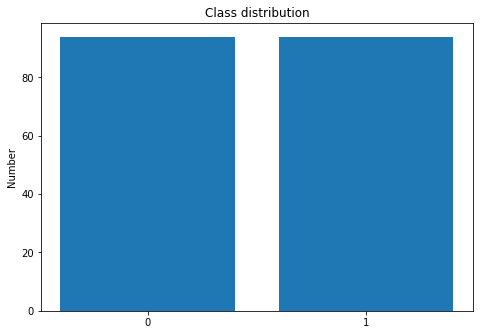

In [244]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(testing_pd['label'].unique(),
       testing_pd.groupby(['label']).count()['text'].tolist())

ax.set_xticks(testing_pd.groupby(['label']).count().index.values)

ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

## 1-2 Tokenization

In [245]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [246]:
from transformers import AutoTokenizer

In [247]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hfl--chinese-bert-wwm/snapshots/ab0aa81da273504efc8540aa4d0bbaa3016a1bb5/config.json
Model config BertConfig {
  "_name_or_path": "hfl/chinese-bert-wwm",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

In [248]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [249]:
full_test_dataset = tokenized_datasets["test"]

# 2. Testing

In [250]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=num_label)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--owen198--weibo-wmmbert-2/snapshots/1c8b069ca4f42474887b1be5ddb45d0b190b785d/config.json
Model config BertConfig {
  "_name_or_path": "owen198/weibo-wmmbert-2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "f

In [251]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## 2-2 Get Accuracy

In [252]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [253]:
import numpy as np

# trainer.evaluate()

In [254]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 188
  Batch size = 8


In [255]:
#get test accuracy
pred.metrics

{'test_loss': 0.8616001605987549,
 'test_accuracy': 0.7925531914893617,
 'test_runtime': 6.1481,
 'test_samples_per_second': 30.579,
 'test_steps_per_second': 3.904}

In [ ]:
pred

In [257]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [258]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

# 3. Analyse predictions

In [259]:

#look at all the results
testing_pd

,text,label,pred
0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0,0
1,#台湾# 深圳卫视正午30分的微博视频,0,1
2,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...,0,0
3,#叨哥有话说# 批台名嘴周玉蔻口无遮拦，马英九：蒋万安应该要告她,0,0
4,很多人根本看不懂国际局势一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。直白一点说，...,0,0
...,...,...,...
55,年底九合一选战渐热，传民进党安排林佳龙转战新北，陈时中则出征北市，形成「龙中配」，而国民党新...,1,1
88,试试能不能发出来蒋孝严诉陈水扁诋毁其祖父案王泽鉴老师的提到过这个案子。昨天准备周五上课的材料...,1,0
60,蒋万安：绝不低头,1,1
96,"台北市民调各有领先,陈时中称比赛刚开始,蒋万安:一定会赢 台湾蒋公子的微博视频",1,1


In [260]:
#see where BERT got it wrong. The count column stands for how many comma's the sentence has... In case we want to consider removing some sentences. 
mistakes_pd = testing_pd.loc[testing_pd['label'] != testing_pd['pred']]
mistakes_pd = (mistakes_pd.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())
mistakes_pd['count'] = mistakes_pd['text'].str.count('，')
mistakes_pd.sort_values(by="count")

,text,label,pred,count
index,,,,
1,#台湾# 深圳卫视正午30分的微博视频,0,1,0
14,"我分享了, 快来看吧！ |",0,1,0
107,曹叡比蒋经国更孝顺母亲！,0,1,0
49,蒋万安：不管姓章还是姓蒋，爱台湾就是我的DNA。 湾湾迷因的微博视频,1,0,1
90,今天记者问蒋万安身世问题蒋万安回答“姓章、姓蒋不重要，爱台湾就是我的DNA”,1,0,1
7,名嘴周玉蔻日前在媒体上攻击蒋万安父亲蒋孝严20几年前诽闻，并且在台北地检署前面与国民党台北市...,0,1,3
22,媒体人周玉蔻近期猛攻国民党台北市长候选人蒋万安家族，更公开高喊“我就是爱阿中！”国民党台北市...,1,0,5
102,国民党台北市长参选人蒋万安抛出“公车预约制”政见，引发可行性质疑。台北市交通局前局长罗孝贤在...,1,0,5
88,试试能不能发出来蒋孝严诉陈水扁诋毁其祖父案王泽鉴老师的提到过这个案子。昨天准备周五上课的材料...,1,0,5


In [261]:
#see where BERT got it right
correct_pd = testing_pd.loc[testing_pd['label'] == testing_pd['pred']]
correct_pd = (correct_pd.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())
correct_pd['count'] = correct_pd['text'].str.count('，')
correct_pd.sort_values(by="count")

,text,label,pred,count
index,,,,
60,蒋万安：绝不低头,1,1,0
109,周玉蔻这条沙皮狗继续狂咬蒋万安父子,0,0,0
96,"台北市民调各有领先,陈时中称比赛刚开始,蒋万安:一定会赢 台湾蒋公子的微博视频",1,1,0
94,陈时中民调垫底 蒋万安直言民众已看清他的虚伪面目 战神_freedomNicky的微博视频,0,0,0
77,#佩洛西访问台湾是危险的挑衅行为#蒋万安什么东西呀？你爷爷和太爷爷知道你这揍像不得气活过来…...,0,0,0
...,...,...,...,...
106,民进党桃园市长参选人林智坚论文争议持续发酵。据台湾中时新闻网9日最新消息，台当局领导人蔡英文...,0,0,34
35,国民党告陈时中渎职 质疑其疫苗采购黑箱操作 中新网9月22日电 据台湾报道，国民党认为参选...,0,0,41
40,综合台媒报道，台媒体人周玉蔻近期争议言论不断，面对外界批评，她透过其创办的放言传媒有限公司...,0,0,44


In [262]:
#correct_count_pd = correct_pd['text'].str.len()
#pd.DataFrame(correct_count_pd)